In [1]:
import pickle
import csv
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras.utils.training_utils import multi_gpu_model
from keras.models import model_from_json
from keras import metrics
from keras.optimizers import SGD
from keras import backend as K
import json
import os
import bcolz as bc
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Generator method
def generator(x, y, batch_size):
    while(True):
        rand_keys = np.random.choice(x.shape[0], batch_size)
        yield x[rand_keys], y[rand_keys]

In [4]:
# Read data files
data_path = 'data/x_train_std/'
x_train = bc.open(data_path)
with open('data/y_train_std.pickle', 'rb') as f:
    y_train = pickle.load(f)
y_train = np.array(y_train, dtype=np.float32)
print(x_train.shape, y_train.shape)

(1338, 170, 284, 247, 8) (1338,)


In [5]:
# bc_features = bc.open('data/bc_features/')
# bc_features.shape

In [6]:
# with open('data/pdb2idx.pickle', 'rb') as f:
#     pdb2idx = pickle.load(f)
# len(pdb2idx)

In [7]:
# with open('data/idx2pdb.pickle', 'rb') as f:
#     idx2pdb = pickle.load(f)
# len(idx2pdb)

In [8]:
# non_trained_ids = [_id for _id in pdb2idx.values() if _id not in idx2pdb.keys()]
# len(non_trained_ids)

In [9]:
# len(trained_pdbs)

In [10]:
# Load the model
with open('new/test_cnn_model_0415.json', 'r') as f:
    loaded_model = f.read()
model = model_from_json(loaded_model)
# model = multi_gpu_model(model, gpus=4)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 83, 140, 122, 16)  16016     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 41, 70, 61, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 39, 68, 59, 32)    13856     
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 19, 34, 29, 32)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 17, 32, 27, 64)    55360     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 16, 13, 64)     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 106496)            0         
__________

In [12]:
model = multi_gpu_model(model, gpus=2)

In [13]:
model.compile(optimizer=SGD(lr = 0.0001),
              loss='mean_squared_error',
              metrics=[metrics.mse])

In [14]:
# Load the weights
model.load_weights('new/weights-improvement-50-6.11.hdf5')

### Evaluate the model

In [15]:
# Get some test data from training data and predict
batch_size = 5
x_test, y_test = next(generator(x_train, y_train, batch_size))
y_pred = model.predict(x_test)
print('Actual values: ', y_test)
print('Predicted data: ', y_pred.flatten())

Actual values:  [ 6.4   5.44  8.05 11.57  5.92]
Predicted data:  [5.827035  5.7435517 5.8223557 5.8141003 5.894643 ]


In [16]:
print("The mean of y_train ", np.mean(y_train))

The mean of y_train  6.47488


In [17]:
y_exp = []
y_predict = []

In [18]:
for _ in range(10):
    bx, y_ = next(generator(x_train, y_train, batch_size))
    y_p = model.predict(bx)
    y_predict = y_predict + y_p.tolist()
    y_exp = y_exp + y_.tolist()

In [19]:
r2 = r2_score(y_pred=y_predict, y_true=y_exp)
r2

-0.05073365680958619

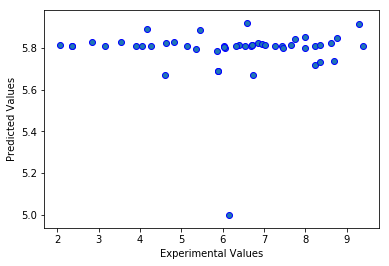

In [20]:
f = plt.figure()
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.scatter(y_exp, y_predict, marker='o', edgecolors='b')
# plt.legend(['Binding Affinity'])
plt.show()

In [21]:
f.savefig('comparison.png')

### Training history

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
with open('new/test_history_0415.pickle', 'rb') as f:
    history = pickle.load(f)

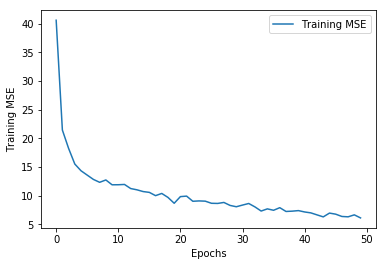

In [23]:
f2 = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
plt.plot(history['loss'], label='Training MSE')
plt.legend()
plt.show()

In [25]:
f2.savefig('training.png')